In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
"""TODO: add control lag, so that each control has lingering effects"""
"""This can be done through any of the following ways:
1) only add/subtract a factor from the existing heating variable
"""
"""TODO: generalize this controller, so the controller itself can be appropriated for other uses"""

In [3]:
k = 2000 # meter * hour * degree, thermal conductivity of a window
D = 0.01 # meter, depth of a window
A = 6 # m^2, area of a window
m = 1470 # kilogram, mass of air in the room
c = 1005.4 # J/(kg * C), heat capacity of air

T_out = -5 # Celsius, temperature outside
T_0 = 15
T_ideal = 25

dt = 0.01 # hour, 0.01 hour = 36s

def heat_loss(T_room):
    return k * A * (T_room - T_out) * D**-1

def temp_change(T_room, heating, dt = 0.01):
    """The change in temperature during a time frame of dt
    
    Args:
        T_room: temperature of the room
        heating: the power input to the room due to heating (J/h)

    Output: 
        temperature change within the time frame dt
    """
    heat_loss = k * A * (T_room - T_out) * D**-1 # Loss rate of thermal energy from the room
    
    dT = (m * c)**-1 * (heating - heat_loss) * dt

    return dT

# simulate until temperature and its derivative are within some acceptable margin
# or until it has been 10 hours

In [48]:
e_integral = 0
T_history = [T_0]

P_history = []
I_history = []
D_history = []

margin = 0.01

def simulate_room(tot_time, dt = 0.01, P_gain = 0, I_gain = 0, D_gain = 0, T_room = T_0, heating = 0, T_last = T_0, elapsed_time = 0, e_integral = 0, loop_count = 0):
    """Given starting temperature, and an initial heating power of 0, simulate the room's temperature change over time
    Args:
        tot_time = total time
    """
    e_t = T_ideal - T_room
    dT_prediction = temp_change(T_room, heating, dt)

    # Proportional control
    P_factor = P_gain * e_t
    
    # Integral control
    e_prediction = T_ideal - dT_prediction
    #e_integral = (e_t + e_prediction) * 0.5 * dt
    e_integral = (T_room + T_last) * dt * 0.5

    I_factor = e_integral * I_gain

    # Derivative control
    D_factor = D_gain * (T_last - T_room)/dt

    # Utilities
    elapsed_time += dt

    # Debug row

    # PID Recursive Loop
    if elapsed_time > tot_time: # or abs(e_t) < margin:
        loop_count += 1
        print (f"{loop_count}. Simulation ended after {elapsed_time} hours, temperature is now at {T_room}. Temperature variance {T_room - T_ideal}")
        
        residual = np.array(T_history) - T_ideal

        P_history.append(P_factor)
        I_history.append(I_factor)
        D_history.append(D_factor)

        time = np.linspace(0, elapsed_time, len(T_history))

        print("Making plots...")

        fig, (T, P, I, D) = plt.subplots(4, 1, figsize = (7, 7))
        T.plot(time, T_history, label = 'T_room')
        #T.plot(time, residual)
        T.hlines(y=T_ideal, xmin=0, xmax=(elapsed_time), color = 'black')
        T.grid()

        temp_list = [P, I, D]
        histories = [P_history, I_history, D_history]
        for i in range(3):
            temp_list[i].plot(time, histories[i], alpha = 0.5, label = '{i} factor', linestyle = '--')
            temp_list[i].set_title("P_factor")
            temp_list[i].grid()
            
        fig.tight_layout()
        
        display_range = 0.5
        #plt.ylim((T_ideal - display_range, T_ideal + display_range))
        return (T_room)
    else: 
        loop_count += 1
        #print (f"{loop_count}, {elapsed_time} hours has passed, temperature is now at {T_room}. dT_prediction {dT_prediction}")#Temperature variance {T_room - T_ideal}")
        T_history.append(T_room)

        P_history.append(P_factor)
        I_history.append(I_factor)
        D_history.append(D_factor)
        #clear_output(wait=True)
        #plt.plot(T_history)

        new_heating = heating + P_factor + I_factor + D_factor
        return simulate_room(tot_time=tot_time, dt=dt, P_gain=P_gain, I_gain=I_gain, D_gain=D_gain, T_room=T_room + dT_prediction, heating=new_heating , T_last=T_room, elapsed_time=elapsed_time, e_integral=e_integral, loop_count=loop_count)

200000. Simulation ended after 1.0000000000023175 hours, temperature is now at 25.008741407345255. Temperature variance 0.00874140734525497
Making plots...


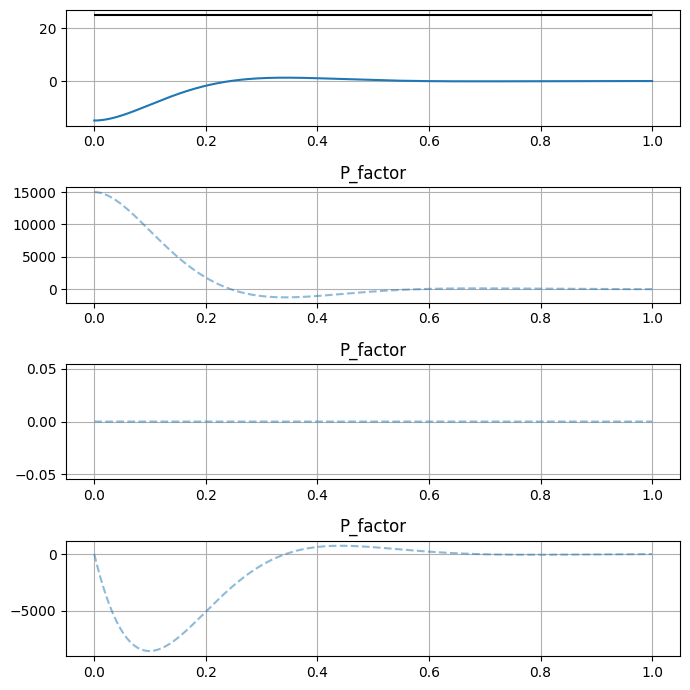

In [47]:
import sys
from IPython.display import clear_output
sys.setrecursionlimit(3000000)

T_ideal = 25
T_0 = 10

T_history = [T_0]
P_history = []
I_history = []
D_history = []

time = []

test = simulate_room(tot_time=1, dt=0.000005, T_room=T_0, P_gain=1000, I_gain=0, D_gain=100, heating=heat_loss(T_0), elapsed_time=0)

In [ ]:
def make_plot(figname, layout=(1,1), axis_names=, ):